# **Homework 1: Regression**

**Creators**:  
- Milad Sangsefidi (milads@uark.edu)  
- Daniel Alejandro Peraza (daperaza@uark.edu)  

**Department**: Mechanical Engineering  
**Course**: Machine Learning for Mechanical Engineering  
**Instructor**: Dr. Han Hu                                      
**Semester**: Fall 2024


# **Tips for Understanding and Using the Code**

## **Purpose of the Code**
- **Primary Objective**:  
  This script predicts heat flux during a transient pool boiling test using **temperature data** with:
  - **Multilayer Perceptron (MLP)** (TensorFlow).
  - **Gaussian Process Regressor (GPR)** (Scikit-learn).

- **Key Techniques**:
  - Data preprocessing (loading, cleaning, and splitting data).
  - Model training and k-fold cross-validation.
  - Visualization of results (loss, RMSE, and predictions).

- **Audience**:  
  Designed for students learning **machine learning regression techniques**.




#**1. Overview**

This Python script implements the workflow for analyzing the relation between temperature and heat flux with MLP and GPR models from scratch. It starts by loading and preprocessing the dataset, visualizing the raw data, and defining functions to build, train, and evaluate the MLP and GPR models. It uses k-fold cross-validation to evaluate model performance on many folds, calculates metrics such as loss and root mean squared error (RMSE), and identifies the best-performing model based on the RMSE value. It also contains functions for result visualization, comparison between model predictions and real data, and metrics per fold. This code is well-structured for the validation of regression models and the comparison of their performance on scientific datasets.

#**2. Import necessary libraries**

This code imports the necessary modules for constructing and fitting machine learning models.
# **Overview of Libraries and Modules**

## **File Handling**
- **`files`**: Used for uploading files in Google Colab.

## **Deep Learning**
- **`tensorflow`**: Enables construction and training of deep learning models.

## **Numerical Computations and Data Manipulation**
- **`numpy`**: Facilitates numerical computations.  
- **`pandas`**: Simplifies data handling and manipulation.

## **Visualization**
- **`matplotlib.pyplot`**: Generates plots and visualizations.  
- **`seaborn`**: Enhances data visualization capabilities.

## **Machine Learning (Scikit-learn)**
- **`train_test_split`**: Splits datasets into training and testing sets.  
- **`KFold` and `cross_val_score`**: Implements cross-validation.  
- **`MLPRegressor`**: Constructs Multilayer Perceptron (MLP) models.  
- **`GaussianProcessRegressor`**: Builds Gaussian Process Regression (GPR) models.  
  - **Kernels**:  
    - **`Radial Basis Function (RBF)`**: A widely used kernel in GPR.  
    - **`Constant Kernel`**: Scales kernel outputs.

## **Model Performance Metrics**
- **`mean_squared_error`**: Evaluates model performance via Mean Squared Error.  
- **`r2_score`**: Computes the R² Score for model assessment.

## **Utility Tools**
- **`time`**: Measures execution time of tasks.  
- **`tqdm`**: Adds progress bars to loops for tracking iterative tasks.


In [ ]:
# Import necessary modules
from google.colab import files
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score
import time
from tqdm import tqdm

#**3. Loading and plotting dataset**

# **Overview of Dataset Handling and Preprocessing**

## **File Uploading**
- **`files.upload()`**:  
  - Allows users to upload a text file (`boiling-32_temp_heat_flux.txt`) from their local device into the Colab environment.

## **Data Loading**
- **`pd.read_csv()`**:  
  - Reads the uploaded file into a pandas DataFrame.  
  - **Parameters**:  
    - **`sep='\t'`**: Specifies tab-separated values.  
    - **`skiprows=1`**: Skips the first row of the file.

## **Data Cleaning**
- **Column Names**:  
  - Cleaned using **`str.strip()`** to remove extra spaces.  
  - Explicitly renamed for clarity if needed.

## **Feature and Target Extraction**
- **Independent Variable (`X`)**:  
  - Extracted as **Temperature (°C)**.  
  - Reshaped into a column vector (**`X.reshape(-1, 1)`**) for compatibility with machine learning models.  
- **Dependent Variable (`y`)**:  
  - Extracted as **Heat flux (W/cm²)**.

## **Data Visualization**
- **Line Plot**:  
  - Visualizes the relationship between **Temperature** and **Heat Flux**.  
  - Includes labeled axes and a descriptive title to aid interpretation.


In [ ]:
# Upload the txt file from local folder
uploaded = files.upload()

Saving boiling-32_temp_heat_flux.txt to boiling-32_temp_heat_flux.txt


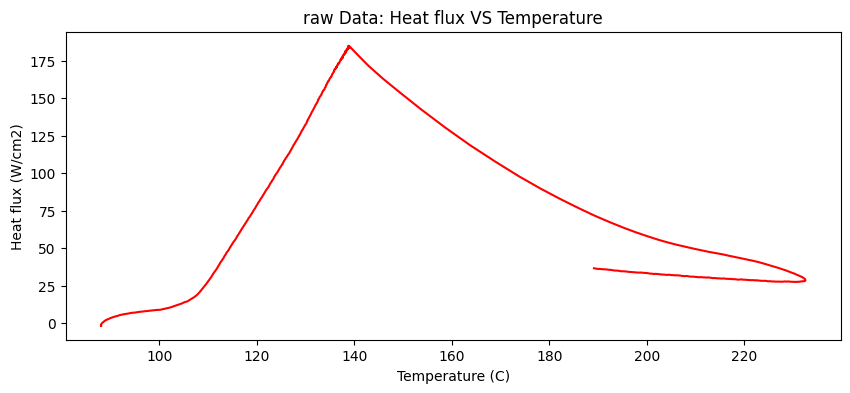

In [ ]:
# Load the data from the txt file, skipping the first row using pandas command
data = pd.read_csv('boiling-32_temp_heat_flux.txt', sep='\t', skiprows=1)

# Example: If column names have extra spaces
data.columns = data.columns.str.strip()

# Alternatively, rename them explicitly
data.columns = ['Temperature (C)', 'Heat flux (W/cm2)']

# Extract the input (X) and output (y) variables
X = data['Temperature (C)'].values.reshape(-1, 1)
y = data['Heat flux (W/cm2)'].values

# Visualize the data using a line plot
plt.figure(figsize=(10, 4))
plt.plot(X, y, color='red')
plt.xlabel('Temperature (C)')
plt.ylabel('Heat flux (W/cm2)')
plt.title('raw Data: Heat flux VS Temperature')
plt.show()

#**4. Multilayer Perceptron (MLP) model**

# **`build_and_train_MLP` Function**

This function builds and trains a **Multilayer Perceptron (MLP)** for regression tasks using TensorFlow/Keras. Here's what the function does:

### Key Components:

1. **Input Layer**  
   - The input layer is defined with `tf.keras.Input`, taking the shape of the input data (`trainX_data.shape[1]`).

2. **Hidden Layers**  
   - Three fully connected (`Dense`) layers with 64, 32, and 16 neurons respectively.  
   - **L2 regularization** (`kernel_regularizer`) is applied to each layer to reduce overfitting.  
   - The activation function is **Leaky ReLU** with an alpha of 0.05, allowing small gradients for negative inputs.

3. **Output Layer**  
   - A single neuron with no activation function is used for regression, providing continuous outputs.

4. **Model Compilation**  
   - **Adam optimizer** is used for adaptive learning rates.  
   - The loss function is **Mean Squared Error (MSE)**, appropriate for regression tasks.  
   - **Root Mean Squared Error (RMSE)** is added as a metric for evaluation.

5. **Early Stopping**  
   - A **callback** is added to monitor the validation loss (`val_loss`).  
   - Training stops automatically if there is no improvement for 8 epochs (`patience=8`).  
   - The model restores the best weights (`restore_best_weights=True`) to avoid overfitting.

6. **Training**  
   - The model trains for up to 50 epochs (`epochs=50`) using mini-batches of size 10 (`batch_size=10`).  
   - Both training and validation data are provided to monitor performance.

7. **Evaluation**  
   - After training, the model is evaluated on validation data, returning:
     - **Validation Loss (MSE)**  
     - **Validation RMSE**

8. **Returns**  
   - The trained model (`neural_net`)  
   - Final validation loss  
   - Final validation RMSE



In [ ]:
def build_and_train_MLP(trainX_data, trainy_labels, validX_data, validy_labels):

 #Define input layer
    inputs = tf.keras.Input(shape=(trainX_data.shape[1],))

    # Define the neural network using functional API
    x = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)
    x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)
    x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)
    outputs = tf.keras.layers.Dense(1)(x)

    # Create model
    neural_net = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and Mean Squared Error loss function
    neural_net.compile(optimizer='adam',
                       loss='mse',
                       metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Implement early stopping to prevent overfitting
    stop_training = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Training
    neural_net.fit(trainX_data, trainy_labels,
                   epochs=50,
                   batch_size=10,
                   validation_data=(validX_data, validy_labels),
                   callbacks=[stop_training],
                   verbose=1)

# Evaluate the trained model on the validation data
    validation_results = neural_net.evaluate(validX_data, validy_labels, verbose=0)

    return neural_net, validation_results[0], validation_results[1]

#**5. Gaussian Process Regression (GPR) model**

# **`build_and_train_GPR` Function**

This function creates and trains a **Gaussian Process Regressor (GPR)** model for regression tasks. Here's a breakdown of the function:

### Key Components:

1. **Kernel Setup**  
   - The model uses the **Radial Basis Function (RBF)** kernel, which defines similarity based on distance.  
   - The kernel's `length_scale` is set to `1.0`, with the length scale bounds fixed to reduce computational overhead.  
   - Alternative bounds (e.g., `(1e-05, 100000.0)`) can be used, but this increases computation time.  
   - The **`n_restarts_optimizer`** parameter is set to `10`, enabling multiple optimizer restarts to find the best solution.

2. **Model Initialization**  
   - The **GaussianProcessRegressor** is instantiated with:  
     - The RBF kernel defined above.  
     - **Alpha** set to `0.001` to account for noise in the data.  
     - `normalize_y=False` to avoid normalizing the target variable.  
     - A fixed random seed (`random_state=1`) for reproducibility.

3. **Data Reshaping and Training**  
   - Training data (`trainX_data`) is reshaped to ensure it is two-dimensional, as required by the GPR model.  
   - The model is trained using the `fit` method with the reshaped training data and labels.

4. **Prediction**  
   - After training, the model predicts target values for the test dataset (`TestX_data`), also reshaped to two dimensions.

5. **Evaluation Metrics**  
   - **Mean Squared Error (MSE)**: Measures average squared differences between predicted and actual values.  
   - **Root Mean Squared Error (RMSE)**: Square root of MSE, representing error in the same units as the target variable.  
   - The metrics are printed for quick reference.

6. **Returns**  
   - The trained GPR model (`gpr_model`).  
   - The computed MSE (`mse_score`) and RMSE (`rmse_score`).




In [ ]:
def build_and_train_GRP(trainX_data, trainy_labels, TestX_data, Testy_labels):

    # Setup RBF kernel with a fixed length scale, also can be used with a number but longer running time
    #rbf_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))
    #n restarts optimizer is for bounding the finite
    rbf_kernel = RBF(length_scale=1.0, length_scale_bounds='fixed')
    gpr_model = GaussianProcessRegressor(kernel=rbf_kernel, alpha=0.001, normalize_y=False, random_state=1, n_restarts_optimizer = 10)

    # Reshape training data to ensure it's two-dimensional and fit the model Use the model to make predictions on the validation dataset
    gpr_model.fit(trainX_data.reshape(-1, 1), trainy_labels)
    predictions = gpr_model.predict(TestX_data.reshape(-1, 1))

    # Compute evaluation metrics
    mse_score = mean_squared_error(Testy_labels, predictions)
    print(f"Mean Squared Error: {mse_score}")
    rmse_score = np.sqrt(mse_score)

    return gpr_model, mse_score, rmse_score

#**6. Training using KFolds Cross-Validation**

# **`perform_k_fold_cv` Function**

This function performs **k-fold cross-validation** for a given model training function. It evaluates the model's performance across multiple splits of the dataset and provides a comprehensive summary of results.

### Key Components:

1. **Inputs**  
   - `model_train_func`: A function to train the model, returning the trained model, loss, and RMSE.  
   - `features`: The input dataset for the model (numpy array or similar format).  
   - `targets`: The output labels corresponding to the features.  
   - `num_folds`: Number of splits for k-fold cross-validation.  
   - `model_identifier`: A label to identify the model (used in the progress bar).

2. **Cross-Validation Setup**  
   - The **`KFold`** object is initialized with:  
     - `n_splits=num_folds` to specify the number of folds.  
     - `shuffle=True` to randomize the dataset before splitting.  
     - `random_state=42` to ensure consistent splits.

3. **Progress Monitoring**  
   - A **tqdm progress bar** monitors the progress of cross-validation, displaying fold-by-fold progress.

4. **Loop Through Folds**  
   - For each fold:
     - Split the dataset into training and validation subsets.
     - Train the model using `model_train_func` with the training data.
     - Record the model, loss, and RMSE for the current fold in a dictionary.

5. **Evaluation Metrics**  
   - Extract losses and RMSEs for each fold.  
   - Identify the **optimal fold** based on the lowest RMSE.  
   - Compute the **average loss** and **average RMSE** across all folds.

6. **Return Values**  
   - A dictionary summarizing the results:
     - `losses_per_fold`: List of loss values for each fold.  
     - `rmses_per_fold`: List of RMSE values for each fold.  
     - `optimal_fold_index`: Index of the best fold based on RMSE.  
     - `best_fold`: Index of the fold with the best performance.  
     - `best_model`: The model trained in the best fold.  
     - `average_loss`: Average loss across all folds.  
     - `average_rmse`: Average RMSE across all folds.




In [ ]:
def perform_k_fold_cv(model_train_func, features, targets, num_folds, model_identifier):
    # Initialize KFold object with shuffle and random seed
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Store results for each fold
    fold_results = [{'model': None, 'loss': None, 'rmse': None} for _ in range(num_folds)]

    # Progress bar for monitoring cross-validation
    with tqdm(total=num_folds, position=0, desc=f'{model_identifier} Progress') as progress_bar:

        # Loop through each fold and perform cross-validation
        for fold_idx, (train_indices, val_indices) in enumerate(kf.split(features)):
            # Split features and targets for training and validation sets
            train_features, val_features = features[train_indices], features[val_indices]
            train_targets, val_targets = targets[train_indices], targets[val_indices]

            # Train the model and obtain loss and RMSE
            model, loss, rmse = model_train_func(train_features, train_targets, val_features, val_targets)

            # Store the results in the dictionary for each fold
            fold_results[fold_idx]['model'] = model
            fold_results[fold_idx]['loss'] = loss
            fold_results[fold_idx]['rmse'] = rmse

            # Update the progress bar after each fold
            progress_bar.update(1)

    # Extract losses and RMSEs for analysis
    losses_per_fold = [fold['loss'] for fold in fold_results]
    rmses_per_fold = [fold['rmse'] for fold in fold_results]

    # Identify the best fold based on RMSE
    optimal_fold_index = np.argmin(rmses_per_fold)

    # Calculate average loss and RMSE across all folds
    average_loss = np.mean(losses_per_fold)
    average_rmse = np.mean(rmses_per_fold)

    # Return the summary dictionary with evaluation metrics
    return {
        'losses_per_fold': losses_per_fold,
        'rmses_per_fold': rmses_per_fold,
        'optimal_fold_index': optimal_fold_index,
        'best_fold': optimal_fold_index,
        'best_model': fold_results[optimal_fold_index]['model'],
        'average_loss': average_loss,
        'average_rmse': average_rmse
    }


#**7. Evaluate the performance of the MLP and GPR models during training**

# **`visualize_comparison` Function**

This function visualizes a side-by-side comparison of the **Loss** and **RMSE** metrics between two models—Multi-Layer Perceptron (MLP) and Gaussian Process Regression (GPR)—across folds in k-fold cross-validation.

---

### Key Components

1. **Input Parameters**
   - `mlp_results`: A dictionary containing MLP's cross-validation results (losses and RMSEs per fold, averages).  
   - `gpr_results`: A dictionary containing GPR's cross-validation results.

2. **Figure and Subplots**
   - Creates a 1-row, 2-column plot layout using Matplotlib:
     - **Left Plot**: Loss comparison.  
     - **Right Plot**: RMSE comparison.

3. **Fold Indices**
   - Determines the x-axis values based on the number of folds (`1` to `n`).

4. **Styling**
   - Predefined plot styles (`color`, `marker`, `linestyle`, `label`) for clear visual distinction:
     - **MLP Loss**: Blue, Circle markers, Solid line.  
     - **GPR Loss**: Red, Square markers, Dashed line.  
     - **MLP RMSE**: Green, Diamond markers, Solid line.  
     - **GPR RMSE**: Magenta, Triangle markers, Dashed line.

5. **`plot_metrics` Helper Function**
   - Handles plotting for each metric (Loss or RMSE):
     - Plots MLP's and GPR's metric values across folds.  
     - Includes legends with the average metric value for each model.  
     - Sets labels, titles, and grid for better readability.

6. **Comparison of Loss**
   - Visualizes the fold-wise Loss for MLP and GPR, alongside their average Loss values.

7. **Comparison of RMSE**
   - Visualizes the fold-wise RMSE for MLP and GPR, alongside their average RMSE values.

8. **Final Layout**
   - Adjusts spacing using `plt.tight_layout()` for a polished appearance.  
   - Displays the plots using `plt.show()`.

---

### Output
The function produces two side-by-side plots:
1. **Loss Comparison**: Per-fold Loss values for MLP and GPR.
2. **RMSE Comparison**: Per-fold RMSE values for MLP and GPR.

Each plot clearly identifies trends and the relative performance of both models, helping to interpret the k-fold cross-validation results effectively.


In [ ]:
def visualize_comparison(mlp_results, gpr_results):
    # Set up the figure and subplots for loss and RMSE comparison
    fig, (loss_ax, rmse_ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

    # Generate fold indices based on the number of folds in the results
    fold_indices = np.arange(1, len(mlp_results['losses_per_fold']) + 1)

    # Define styling for MLP and GPR with distinct colors
    plot_settings = {
        'mlp_loss': {'color': 'b', 'marker': 'o', 'linestyle': '-', 'label': 'MLP Loss'},
        'gpr_loss': {'color': 'r', 'marker': 's', 'linestyle': '--', 'label': 'GPR Loss'},
        'mlp_rmse': {'color': 'g', 'marker': 'D', 'linestyle': '-', 'label': 'MLP RMSE'},
        'gpr_rmse': {'color': 'm', 'marker': '^', 'linestyle': '--', 'label': 'GPR RMSE'}
    }

    # Function to handle plotting for each metric
    def plot_metrics(ax, metric_name, mlp_metric, gpr_metric, settings_mlp, settings_gpr, avg_mlp, avg_gpr):
        # Plot MLP metric
        ax.plot(fold_indices, mlp_metric, marker=settings_mlp['marker'], linestyle=settings_mlp['linestyle'], color=settings_mlp['color'],
                label=f'{settings_mlp["label"]} (Avg: {avg_mlp:.4f})')
        # Plot GPR metric
        ax.plot(fold_indices, gpr_metric, marker=settings_gpr['marker'], linestyle=settings_gpr['linestyle'], color=settings_gpr['color'],
                label=f'{settings_gpr["label"]} (Avg: {avg_gpr:.4f})')

        ax.set_xlabel('Fold Index')
        ax.set_ylabel(metric_name)
        ax.set_title(f'{metric_name} per Fold Comparison')
        ax.legend()
        ax.grid(True)

    # Plot Loss comparison
    plot_metrics(loss_ax, 'Loss', mlp_results['losses_per_fold'], gpr_results['losses_per_fold'],
                 plot_settings['mlp_loss'], plot_settings['gpr_loss'],
                 mlp_results['average_loss'], gpr_results['average_loss'])

    # Plot RMSE comparison
    plot_metrics(rmse_ax, 'RMSE', mlp_results['rmses_per_fold'], gpr_results['rmses_per_fold'],
                 plot_settings['mlp_rmse'], plot_settings['gpr_rmse'],
                 mlp_results['average_rmse'], gpr_results['average_rmse'])

    # Adjust the layout and show the plots
    plt.tight_layout()
    plt.show()


#**8. Evaluate of the MLP and GPR models performance**

# **`visualize_predictions` Function**

This function visualizes the performance of the Multi-Layer Perceptron (MLP) and Gaussian Process Regression (GPR) models by comparing their predictions with actual values for heat flux and plotting residuals and accuracies.

---

### Key Components

1. **Input Parameters**
   - `mlp_results`, `gpr_results`: Cross-validation results containing the best models and their respective folds.
   - `X_test`, `y_test`: Test dataset (features and target values).
   - `residual_threshold`: A threshold (default `0.05`) for calculating model accuracy in terms of acceptable residuals.

2. **Model Predictions**
   - Extracts the best models from results.
   - Generates predictions for `X_test` using both MLP and GPR models.

3. **Visualization Layout**
   - Creates a 3-row, 2-column plot layout:
     - Row 1: MLP predictions.
     - Row 2: GPR predictions.
     - Row 3: Residuals comparison.

4. **Reusable Plot Functions**
   - **`plot_predictions`**: Visualizes actual vs. predicted heat flux for a model:
     - Includes an ideal line for reference.
   - **`plot_vs_temp`**: Visualizes predicted vs. actual heat flux as a function of temperature.

5. **Residual Analysis**
   - Calculates residuals: \( \text{Residuals} = \text{Actual Heat Flux} - \text{Predicted Heat Flux} \).
   - Calculates accuracy: Percentage of predictions within the residual threshold.

6. **Residuals Plot**
   - Compares residuals of MLP and GPR:
     - Includes a zero-residual reference line.
     - Displays model accuracies in the legend.

7. **Results Presentation**
   - Organizes subplots with `plt.tight_layout()` for clarity.
   - Highlights accuracy differences between models.

---

### Output

The function generates a figure with six subplots:

1. **MLP Predictions vs. Actual Heat Flux**  
2. **MLP Heat Flux vs. Temperature**  
3. **GPR Predictions vs. Actual Heat Flux**  
4. **GPR Heat Flux vs. Temperature**  
5. **Residuals Comparison (MLP vs. GPR)**

### Key Insights

- The comparison of actual vs. predicted values reveals how closely each model matches the data.
- Residual plots highlight systematic errors or trends.
- Accuracy percentages summarize the performance of each model under the defined residual threshold.


In [ ]:
def visualize_predictions(mlp_results, gpr_results, X_test, y_test, residual_threshold=0.05):
    # Ensure that both models are available
    mlp_model, gpr_model = mlp_results.get('best_model'), gpr_results.get('best_model')
    if None in (mlp_model, gpr_model):
        raise ValueError("Missing one or both models (MLP, GPR).")

    # Perform predictions with both models
    mlp_preds = mlp_model.predict(X_test).squeeze()
    gpr_preds = gpr_model.predict(X_test.reshape(-1, 1))
    preds_dict = {'MLP': mlp_preds, 'GPR': gpr_preds}

    # Set figure layout with size
    fig, axs = plt.subplots(3, 2, figsize=(20, 15))

    # Define reusable plot function for predictions vs actuals
    def plot_predictions(ax, true_vals, pred_vals, model, fold, title):
        ax.scatter(true_vals, pred_vals, c='blue', edgecolor='k', alpha=0.7, label=f'{model} Predictions')
        ax.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--', label='Ideal Line')
        ax.set(xlabel='Actual Heat Flux', ylabel='Predicted Heat Flux', title=title)
        ax.legend()
        ax.grid(True)

    # Define reusable plot function for heat flux vs temperature
    def plot_vs_temp(ax, X, true_vals, pred_vals, model, fold, title):
        ax.scatter(X, true_vals, c='darkblue', edgecolor='k', alpha=0.6, label='Actual Data')
        ax.scatter(X, pred_vals, c='darkred', edgecolor='k', alpha=0.6, label=f'{model} Predictions')
        ax.set(xlabel='Temperature', ylabel='Heat Flux', title=title)
        ax.legend()
        ax.grid(True)

    # Plot predicted vs actual and predicted vs temperature for both models
    for i, (model, preds) in enumerate(preds_dict.items()):
        fold_idx = mlp_results['best_fold'] if model == 'MLP' else gpr_results['best_fold']
        plot_predictions(axs[i, 0], y_test, preds, model, fold_idx + 1, f'{model} Predictions vs Actual Heat Flux (Best Fold: {fold_idx + 1})')
        plot_vs_temp(axs[i, 1], X_test, y_test, preds, model, fold_idx + 1, f'{model} Heat Flux vs Temperature (Best Fold: {fold_idx + 1})')

    # Calculate residuals and accuracy for both models
    residuals = {model: y_test - preds for model, preds in preds_dict.items()}
    accuracies = {model: np.mean(np.abs(residuals[model]) <= residual_threshold * np.abs(y_test)) * 100 for model in residuals}

    # Plot residuals comparison
    axs[2, 0].scatter(X_test, residuals['MLP'], c='blue', edgecolor='k', alpha=0.5, label=f'MLP Residuals (Accuracy: {accuracies["MLP"]:.2f}%)')
    axs[2, 0].scatter(X_test, residuals['GPR'], c='red', edgecolor='k', alpha=0.5, label=f'GPR Residuals (Accuracy: {accuracies["GPR"]:.2f}%)')
    axs[2, 0].axhline(0, color='green', linestyle='--', linewidth=1, label='Zero Residual')
    axs[2, 0].set(xlabel='Temperature', ylabel='Residuals', title='Residuals Comparison between MLP and GPR')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    # Adjust layout for better visibility
    plt.tight_layout()

    # Display the plots
    plt.show()

#**9. Running**

The data is split into training (80%) and test (20%) sets, and 10-fold cross-validation is performed on both MLP and GPR models. The performance of each model is evaluated, and loss and RMSE comparisons are visualized. Additionally, predictions on the test set are plotted, showing actual vs. predicted values and residuals for model comparison.

MLP Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7608.3154 - root_mean_squared_error: 86.8201 - val_loss: 5984.3643 - val_root_mean_squared_error: 77.3497
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6161.1401 - root_mean_squared_error: 78.4833 - val_loss: 5984.7993 - val_root_mean_squared_error: 77.3528
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5907.8979 - root_mean_squared_error: 76.8451 - val_loss: 5988.4883 - val_root_mean_squared_error: 77.3768
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6122.8550 - root_mean_squared_error: 78.2362 - val_loss: 5900.6348 - val_root_mean_squared_error: 76.8072
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6073.0527 - root_mean_squared_error: 77.9168 - val_loss: 5854.0015 - val_root_mean_squared_error: 76.5032
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5959.7832 - root_mean_squared_error: 77.1899 - val_loss: 5721.4839 - val_root_mean_squared_error: 75.6320
Epoc

MLP Progress:  10%|█         | 1/10 [01:11<10:41, 71.33s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6238.0957 - root_mean_squared_error: 78.9498 - val_loss: 6108.7158 - val_root_mean_squared_error: 78.1500
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6037.3423 - root_mean_squared_error: 77.6878 - val_loss: 6146.5024 - val_root_mean_squared_error: 78.3916
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6074.0059 - root_mean_squared_error: 77.9256 - val_loss: 6136.1646 - val_root_mean_squared_error: 78.3258
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5982.7817 - root_mean_squared_error: 77.3329 - val_loss: 5868.8804 - val_root_mean_squared_error: 76.6003
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5880.6958 - root_mean_squared_error: 76.6728 - val_loss: 5474.2764 - val_root_mean_squared_error: 73.9784
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5420.9819 - root_mean_squared_error: 73.6006 - val_loss: 4046.8186 - val_root_mean_squared_error: 63.5984
Epoc

MLP Progress:  20%|██        | 2/10 [02:14<08:52, 66.56s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6512.9736 - root_mean_squared_error: 80.6189 - val_loss: 6167.6450 - val_root_mean_squared_error: 78.5259
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6120.7993 - root_mean_squared_error: 78.2252 - val_loss: 6439.6782 - val_root_mean_squared_error: 80.2396
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5964.6826 - root_mean_squared_error: 77.2156 - val_loss: 6115.5254 - val_root_mean_squared_error: 78.1938
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5956.2661 - root_mean_squared_error: 77.1660 - val_loss: 6000.6831 - val_root_mean_squared_error: 77.4560
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6033.6743 - root_mean_squared_error: 77.6673 - val_loss: 6131.0854 - val_root_mean_squared_error: 78.2932
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5854.5879 - root_mean_squared_error: 76.4982 - val_loss: 5737.7915 - val_root_mean_squared_error: 75.7392
Epoc

MLP Progress:  30%|███       | 3/10 [03:07<07:03, 60.48s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6347.1816 - root_mean_squared_error: 79.6496 - val_loss: 6294.4946 - val_root_mean_squared_error: 79.3300
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6063.0820 - root_mean_squared_error: 77.8546 - val_loss: 6065.2109 - val_root_mean_squared_error: 77.8718
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6100.5513 - root_mean_squared_error: 78.0793 - val_loss: 6309.8335 - val_root_mean_squared_error: 79.4272
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5938.1577 - root_mean_squared_error: 77.0456 - val_loss: 6140.6987 - val_root_mean_squared_error: 78.3554
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5958.5322 - root_mean_squared_error: 77.1801 - val_loss: 5893.1558 - val_root_mean_squared_error: 76.7596
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5778.9092 - root_mean_squared_error: 76.0093 - val_loss: 5635.1035 - val_root_mean_squared_error: 75.0593
Epoc

MLP Progress:  40%|████      | 4/10 [04:13<06:14, 62.36s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6928.1050 - root_mean_squared_error: 82.9610 - val_loss: 5736.0215 - val_root_mean_squared_error: 75.7277
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6088.6807 - root_mean_squared_error: 78.0166 - val_loss: 5673.4546 - val_root_mean_squared_error: 75.3136
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6204.8989 - root_mean_squared_error: 78.7605 - val_loss: 5659.4795 - val_root_mean_squared_error: 75.2210
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6051.1880 - root_mean_squared_error: 77.7762 - val_loss: 5568.5342 - val_root_mean_squared_error: 74.6140
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6021.0703 - root_mean_squared_error: 77.5803 - val_loss: 5481.3164 - val_root_mean_squared_error: 74.0272
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5945.8228 - root_mean_squared_error: 77.0965 - val_loss: 5397.4722 - val_root_mean_squared_error: 73.4582
Epoc

MLP Progress:  50%|█████     | 5/10 [05:22<05:24, 64.90s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7768.3589 - root_mean_squared_error: 87.6593 - val_loss: 6268.4370 - val_root_mean_squared_error: 79.1648
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6057.9575 - root_mean_squared_error: 77.8195 - val_loss: 6224.7593 - val_root_mean_squared_error: 78.8887
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6137.9189 - root_mean_squared_error: 78.3340 - val_loss: 6216.3306 - val_root_mean_squared_error: 78.8354
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5992.9214 - root_mean_squared_error: 77.4049 - val_loss: 6138.4028 - val_root_mean_squared_error: 78.3398
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5977.1475 - root_mean_squared_error: 77.3007 - val_loss: 6120.5879 - val_root_mean_squared_error: 78.2261
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5883.5244 - root_mean_squared_error: 76.6880 - val_loss: 5993.7061 - val_root_mean_squared_error: 77.4107
Epoc

MLP Progress:  60%|██████    | 6/10 [06:30<04:23, 65.88s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6925.4316 - root_mean_squared_error: 83.0265 - val_loss: 6109.0654 - val_root_mean_squared_error: 78.1517
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6083.4272 - root_mean_squared_error: 77.9834 - val_loss: 6091.8550 - val_root_mean_squared_error: 78.0417
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5956.7207 - root_mean_squared_error: 77.1646 - val_loss: 5950.1362 - val_root_mean_squared_error: 77.1284
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5921.9819 - root_mean_squared_error: 76.9428 - val_loss: 5959.2573 - val_root_mean_squared_error: 77.1876
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5872.3442 - root_mean_squared_error: 76.6183 - val_loss: 5798.1621 - val_root_mean_squared_error: 76.1368
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5767.1660 - root_mean_squared_error: 75.9310 - val_loss: 5511.9258 - val_root_mean_squared_error: 74.2323
Epoc

MLP Progress:  70%|███████   | 7/10 [07:12<02:54, 58.27s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6426.6372 - root_mean_squared_error: 80.1192 - val_loss: 6121.6196 - val_root_mean_squared_error: 78.2327
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6058.3193 - root_mean_squared_error: 77.8258 - val_loss: 6076.2036 - val_root_mean_squared_error: 77.9421
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6093.4170 - root_mean_squared_error: 78.0498 - val_loss: 6062.1196 - val_root_mean_squared_error: 77.8518
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6105.3906 - root_mean_squared_error: 78.1219 - val_loss: 5956.3169 - val_root_mean_squared_error: 77.1694
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5899.9238 - root_mean_squared_error: 76.7899 - val_loss: 5844.7290 - val_root_mean_squared_error: 76.4427
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5665.5415 - root_mean_squared_error: 75.2580 - val_loss: 5272.0000 - val_root_mean_squared_error: 72.5982
Epoc

MLP Progress:  80%|████████  | 8/10 [08:19<02:01, 60.86s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6492.8809 - root_mean_squared_error: 80.5366 - val_loss: 6323.4121 - val_root_mean_squared_error: 79.5114
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6038.6367 - root_mean_squared_error: 77.6967 - val_loss: 6454.2905 - val_root_mean_squared_error: 80.3305
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6098.6069 - root_mean_squared_error: 78.0840 - val_loss: 6211.5688 - val_root_mean_squared_error: 78.8054
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5893.7974 - root_mean_squared_error: 76.7561 - val_loss: 6543.9443 - val_root_mean_squared_error: 80.8868
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5923.0332 - root_mean_squared_error: 76.9486 - val_loss: 6265.1108 - val_root_mean_squared_error: 79.1442
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5678.4277 - root_mean_squared_error: 75.3449 - val_loss: 5739.6016 - val_root_mean_squared_error: 75.7506
Epoc

MLP Progress:  90%|█████████ | 9/10 [09:24<01:02, 62.27s/it]

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6315.2920 - root_mean_squared_error: 79.4475 - val_loss: 5966.7300 - val_root_mean_squared_error: 77.2359
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6066.5293 - root_mean_squared_error: 77.8758 - val_loss: 5848.5029 - val_root_mean_squared_error: 76.4671
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6013.0850 - root_mean_squared_error: 77.5276 - val_loss: 5819.0205 - val_root_mean_squared_error: 76.2743
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5968.1909 - root_mean_squared_error: 77.2367 - val_loss: 5757.1167 - val_root_mean_squared_error: 75.8675
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5983.3276 - root_mean_squared_error: 77.3415 - val_loss: 5683.5303 - val_root_mean_squared_error: 75.3807
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5771.1001 - root_mean_squared_error: 75.9556 - val_loss: 5322.3438 - val_root_mean_squared_error: 72.9446
Epoc

GPR Progress:  10%|█         | 1/10 [00:04<00:37,  4.12s/it]

Mean Squared Error: 7.586086112004755


GPR Progress:  20%|██        | 2/10 [00:18<01:20, 10.05s/it]

Mean Squared Error: 10.828014800332301


GPR Progress:  30%|███       | 3/10 [00:25<01:00,  8.65s/it]

Mean Squared Error: 15.669723215106883


GPR Progress:  40%|████      | 4/10 [00:30<00:43,  7.22s/it]

Mean Squared Error: 9.586183317731747


GPR Progress:  50%|█████     | 5/10 [00:36<00:34,  6.94s/it]

Mean Squared Error: 13.063889862084467


GPR Progress:  60%|██████    | 6/10 [00:42<00:26,  6.56s/it]

Mean Squared Error: 9.182529958659478


GPR Progress:  70%|███████   | 7/10 [00:45<00:15,  5.32s/it]

Mean Squared Error: 12.59392301705105


GPR Progress:  80%|████████  | 8/10 [00:52<00:11,  5.81s/it]

Mean Squared Error: 6.546406031904839


GPR Progress:  90%|█████████ | 9/10 [00:57<00:05,  5.75s/it]

Mean Squared Error: 12.357115467130402


GPR Progress: 100%|██████████| 10/10 [01:00<00:00,  6.07s/it]

Mean Squared Error: 8.39825900215596


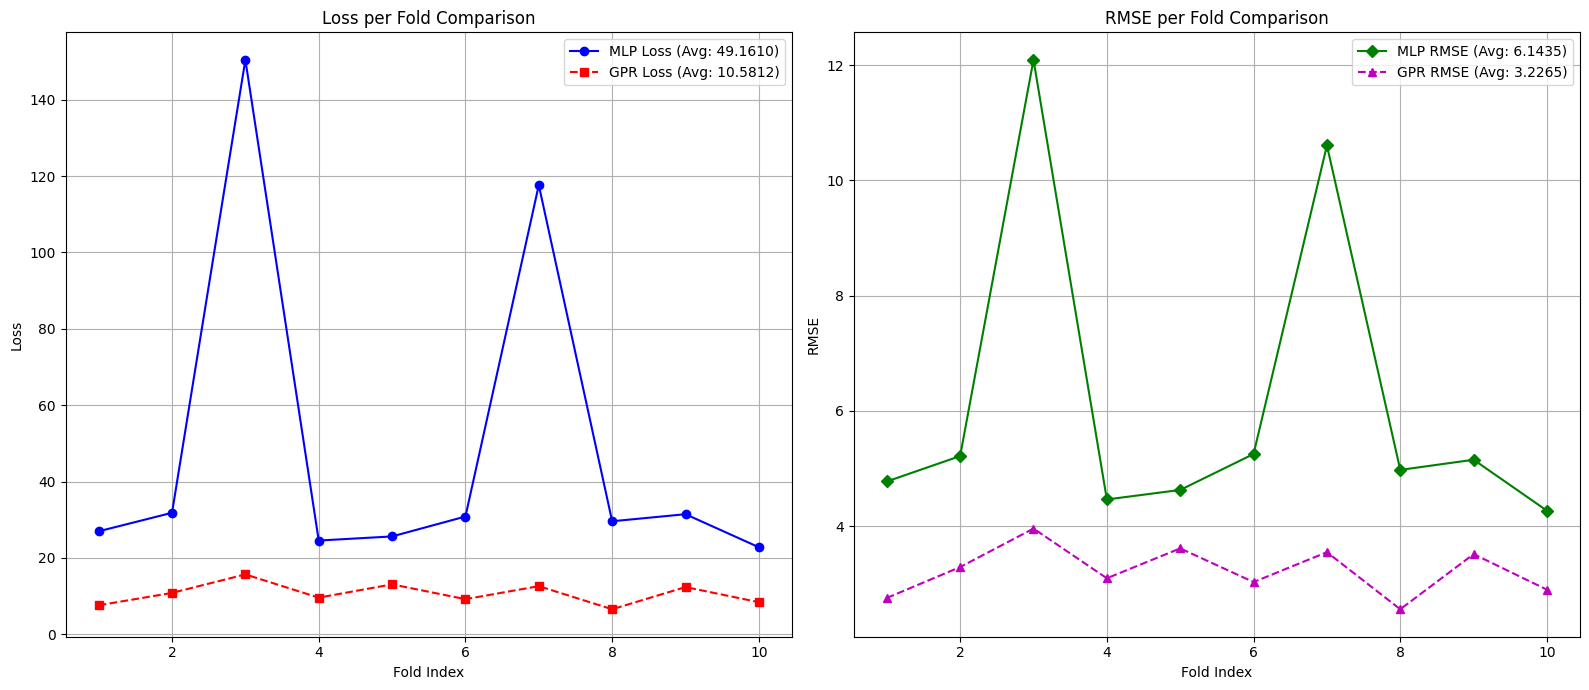

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


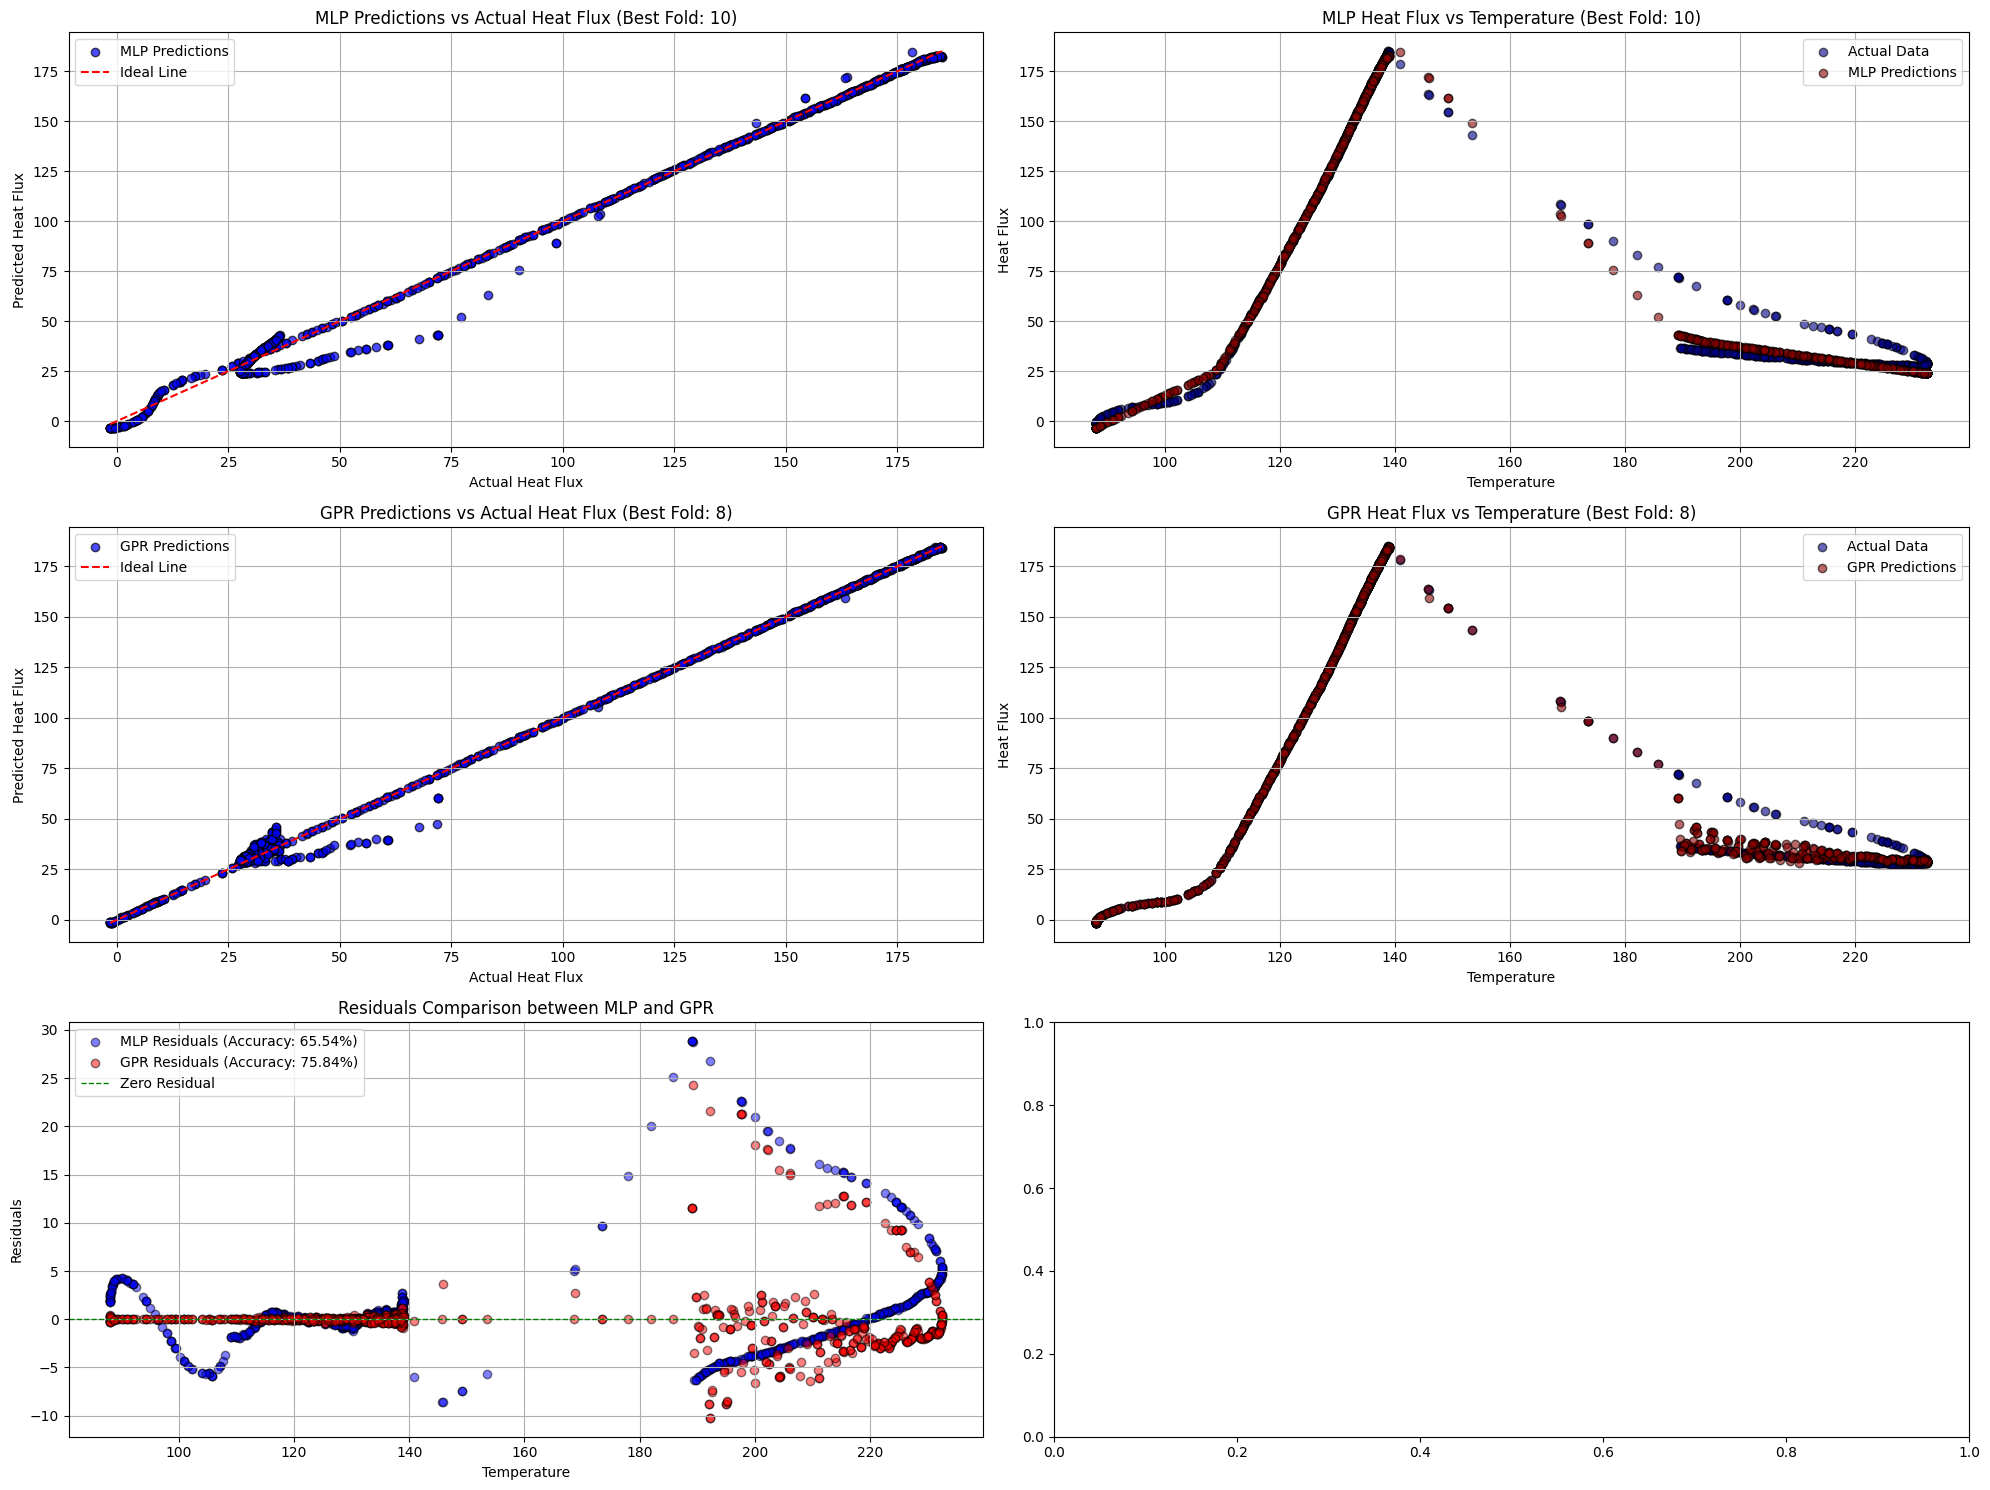

In [ ]:
# Split the data into a temporary set (for cross-validation) and a test set.
features, X_test, targets, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Specify the number of folds for k-fold cross-validation.
n_splits = 10


# Perform k-fold cross-validation for both the MLP and GPR models.
results_mlp = perform_k_fold_cv(build_and_train_MLP, features, targets, n_splits, "MLP")
results_gpr = perform_k_fold_cv(build_and_train_GRP, features, targets, n_splits, "GPR")

# Visualize the comparison of loss and RMSE between the MLP and GPR models.
visualize_comparison(results_mlp, results_gpr)

# Visualize the prediction results for the best MLP and GPR models on the test set.
visualize_predictions(results_mlp, results_gpr, X_test, y_test, residual_threshold=0.05)